## Table of Contents
- [Background](#background)

Data prep

- [Data sources](#data_sources)
- [Geocode locations](#geocode)
- [Calculate distance between HDB flat and nearest amenity](#calculate_distance)
- [Data fixes](#data_fixes)
- [Feature engineering](#feature_engineering)

Data analysis

- [Visualise relationship between distance of flat to amenity and resale price](#relationship)
- [Calculate correlation coefficients](#correlation_matrix)
- [Analyse data using multiple linear regression model](#analysis)
- [Limitations](#limitations)

<a id='background'></a>
## Background

Do a quick online search on what affects home prices around the world and you would be bombarded with many articles.

For example, studies such as [Park and colleagues (2017)](https://www.researchgate.net/publication/313016647_Park_Accessibility_Impacts_Housing_Prices_in_Seoul) and [Wittowsky and colleagues (2020)](https://www.tandfonline.com/doi/full/10.1080/21650020.2019.1704429) talk about drivers of residential housing prices in their respective home countries (in this case, Korea and Germany). The authors observed that the accessibility of a home to nearby public amenities play a role in affecting home prices.

While not exhaustive, we may generally class the myriad of factors that affect home prices into:

- Home characteristics: Size, number of bedrooms, number of bathrooms, building age etc
    
- Neighborhood characteristics: Availability of amenities, distance to nearest public transport, shopping mall etc
    
- Environment characteristics: Surrounding greenery, distance to nearest park etc
    
In Singapore, depending on which market segment a home is located at, namely the [CCR, RCR, and OCR areas](https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-2104), the average prices of homes may differ significantly.  

For example, homes in the CCR area are typically characterized by high-end, luxury homes, most of which are private residential properties and are freehold in tenure. The RCR area is regarded as mid-tier in home pricing, whereas the OCR area typically commands properties that are of the lower price range. 

In addition, different types of HDB flat have also commanded stark differences in pricing. 

For example, executive HDB flats have typically registered higher prices than the 1-room, 2-room or 3-room flats. This may however be attributed to the size of a flat, with an executive flat sized larger than the other flats. 

Bearing in mind that there are many factors that affect home prices, **this exercise will only see me focus on home- and infrastructure-related factors such as the the age of a building, the location of a home, the type of a home, and the distance of a home to nearby amenities such as an MRT station, shopping mall, schools etc.**

As such, I will be using a **multiple linear regression model** to determine if these factors affect HDB resale prices in Singapore. I will approach this problem from a statistical inference perspective, where I subject my variables of interest to hypothesis testing. 

Why Singapore? Simply because the data on HDB prices is readily and pretty comprehensively available through the Singapore government database [here](https://data.gov.sg/dataset/resale-flat-prices?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee), and it'd be interesting to learn more about HDB flats in my neighboring country of sunny Singapore. 

<a id='data_sources'></a>
## Data sources

The variables of interest that I wish to analyse in relation to HDB resale price are:

- Home characteristics: Flat size, flat storey, building age, flat type.
- Neighborhood characteristics: Distance to nearest MRT, mall, CBD, public park, primary school, secondary school, location of flat in market segment (CCR, RCR, OCR).

**1) HDB resale price**

I will extract the HDB resale prices from [data.gov.sg](https://data.gov.sg/dataset/resale-flat-prices?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee) using its API. Resale prices span from 1999 onwards.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import json
import requests
from itertools import islice
from bs4 import BeautifulSoup
from urllib.request import urlopen
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

I will use the requests package to query the data.

In [2]:
# List all urls
url_list = ['https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=500000',
            'https://data.gov.sg/api/action/datastore_search?resource_id=1b702208-44bf-4829-b620-4615ee19b57c&limit=500000',
            'https://data.gov.sg/api/action/datastore_search?resource_id=83b2fc37-ce8c-4df4-968b-370fd818138b&limit=500000',
            'https://data.gov.sg/api/action/datastore_search?resource_id=8c00bf08-9124-479e-aeca-7cc411d884c4&limit=500000',
            'https://data.gov.sg/api/action/datastore_search?resource_id=adbbddd3-30e2-445f-a123-29bee150a6fe&limit=500000']

# Store queried data into a dataframe called hdb_df
hdb_df = pd.DataFrame()

# Loop through all urls listed above to query data
for url in tqdm(url_list):
    # Query data
    response = requests.get(url)
    
    # Convert JSON to Python object
    data = json.loads(response.content)
    
    # Data is nested under 'result' and 'records'
    data_dict = data['result']['records']
    
    # Convert dictionary to dataframe
    hdb = pd.DataFrame(data_dict)
    
    hdb_df = pd.concat([hdb, hdb_df])
    
hdb_df = hdb_df.reset_index(drop=True)

100%|██████████| 5/5 [01:26<00:00, 17.33s/it]


The dataset has 826,533 rows, which consists of the addresses of each resold HDB (town, street name), the date in which they were sold at, flat type (1-, 2-, 3-, 4-, 5-room, executive), floor number, floor area in squater meter, remaining lease in years, resale price.

Below is a sample of 5 rows.

In [3]:
hdb_df = pd.read_csv('./data/0_hdb_df.csv')

/opt/anaconda3/envs/udacity_nanodegree/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Look at first five rows of queried dataset
hdb_df.sample(5)

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,remaining_lease
386844,TAMPINES,5 ROOM,Improved,126.0,TAMPINES AVE 9,339000.0,2002-09,1993,13 TO 15,99646,491A,NaN
118650,HOUGANG,4 ROOM,NEW GENERATION,96.0,HOUGANG AVE 5,245000.0,1996-03,1983,07 TO 09,118651,321,NaN
500181,TOA PAYOH,4 ROOM,Model A,104.0,LOR 1 TOA PAYOH,335000.0,2006-07,1995,01 TO 03,212984,171,NaN
600784,PASIR RIS,EXECUTIVE,Maisonette,146.0,PASIR RIS DR 6,515000.0,2010-02,1989,04 TO 06,313585,418,NaN
757322,HOUGANG,5 ROOM,Improved,120.0,HOUGANG ST 92,495000.0,2018-07,1998,07 TO 09,11115,942,79 years 02 months


**2) Consumer Price Index (CPI)**

I will also be adjusting the HDB resale prices for inflation to dollars in 2020, using the annual CPI that may be found also on [data.gov.sg](https://data.gov.sg/dataset/consumer-price-index-annual).

The formula to adjusted for inflation is:

> adjusted_value = (old_value * cpi_current) / cpi_old

To do this, I first create a dictionary of keys (year) and values (CPI for that year). 

This allows me divide each price value by the CPI of the year in which the transaction was made.

We see that resale prices have been increasing over the years.

In [5]:
cpi_df = pd.read_csv('./data/1_cpi_df.csv')

# Create a dictionary of each year and their corresponding CPI
cpi_map = cpi_df.set_index('year').to_dict()['all_items_value']

# Seperate the years and months of each resale date
hdb_df['resale_year'] = pd.to_datetime(hdb_df['month']).dt.year
hdb_df = hdb_df.rename(columns = {'month':'resale_date'})

# Adjust prices to 2020 dollars. For prices in 2021, retain 2021 resale prices
hdb_df['resale_price_adjusted'] = hdb_df.apply(lambda x: (x['resale_price']*cpi_map[2020])/cpi_map[x['resale_year']] if x['resale_year'] != 2021 else x['resale_price'], axis=1)

In [6]:
resale_price_year = hdb_df.groupby(['resale_year'])['resale_price', 'resale_price_adjusted'].mean().reset_index()

<ipython-input-6-59cb2aa2f8ae>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  resale_price_year = hdb_df.groupby(['resale_year'])['resale_price', 'resale_price_adjusted'].mean().reset_index()


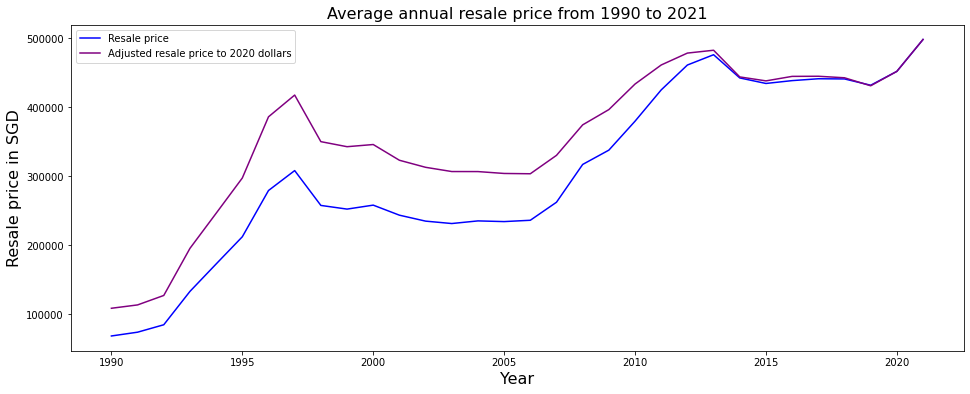

In [7]:
plt.figure(figsize=[16,6])

plt.plot(resale_price_year['resale_year'], resale_price_year['resale_price'], 
         color='blue', label='Resale price')
plt.plot(resale_price_year['resale_year'], resale_price_year['resale_price_adjusted'], 
         color='purple', label='Adjusted resale price to 2020 dollars')

plt.title('Average annual resale price from 1990 to 2021', size=16)
plt.xlabel('Year', size=16)
plt.ylabel('Resale price in SGD', size=16)

plt.legend();

**3) Amenities**

For my infrastructure-related factors, I will be looking at the distance of HDB flats to their nearest amenities of: **MRT stations, shopping malls, central business districts (CBD), public parks, primary schools, and secondary schools.**

I used various Wikipedia pages to get my lists of amenities, using Beautifulsoup to scrape the data where lists are extensive (such as with MRT stations), and good o' copy and paste where there are only a few destinations to record (such as public parks).

An example of me using BeautifulSoup to scrape data is as follows:

In [8]:
# Parse Wikipedia url for Sg's MRT stations into BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

Based on the html of the MRT table on the Wikipedia page, the data are nested under `<tbody>`.

Each row of data of the MRT table (which contains each station's information such as operational status, location, year of opening) are further embedded under `<tr>`.

So, to capture all rows of data, I'd need to loop across each html code under `<tr>` to extract the information that I want, and store them in a dataframe. 

I will only be extracting the MRT station names in English, location of each station, and the operational status. 

The operational status is needed to differentiate MRT stations that are currently operational and those that are incoming. 

My analysis would only take into account MRT stations that are in operation.

In [9]:
# Each row of MRT station and its information are stored under `<tr>`
for i in range(3,7):
    print(f"\nMRT station no. {i-2} \n")
    mrt = soup.find_all('tbody')[1].find_all('tr')[i]
    for j in range(1,9):
        try:
            mrt_text = mrt.find_all('td')[j].text.strip()
            print(mrt_text)
        except: 
            pass


MRT station no. 1 

Jurong East
裕廊东
ஜூரோங் கிழக்கு
10 March 1990
Jurong East
JUR
Jurong East
Jurong East Temporary Bus Interchange

MRT station no. 2 

Bukit Batok
武吉巴督
புக்கிட் பாத்தோக்
Bukit Batok South
BBT
Bukit Batok
Bukit Batok Bus Interchange

MRT station no. 3 

Bukit Gombak
武吉甘柏
புக்கிட் கோம்பாக்
Bukit Batok North
BGB
Bukit Batok


MRT station no. 4 

Brickland
红砖
பிரிக்லேன்ட்
Mid-2030s
Brickland
TBA
Exact location not yet known



In [10]:
# Extract data
# Initialise empty list
mrt_list = defaultdict(list)

# Store data into mrt_list
try:
    for i in range(3, 500): # Staring from the 3rd index because the 1st and 2nd are the headers
        mrt = soup.find_all('tbody')[1].find_all('tr')[i]
        for j in [0, 1, -2]: # I only want the operational status, station name and location
            try:
                mrt_text = mrt.find_all('td')[j].text.strip()
                mrt_list[j].append(mrt_text)
            except:
                mrt_list[j].append('no data')
except:
    pass

# Convert list into a dataframe
mrt_df = pd.DataFrame(mrt_list).rename(columns={0:'operational_status',
                                                1:'station_name',
                                                -2:'location'})

mrt_df.sample(5)

,operational_status,station_name,location
29,East West Line (EWL),no data,no data
47,EW18,Redhill,Bukit Merah
116,Circle Line Stage 6,no data,no data
65,CG2,Changi Airport,Changi
100,CC14,Lorong Chuan,Serangoon


According to the extracted results, there are 123 MRT stations that are currently in operation.

I will extract the remaining amenities from Wikipedia also.

<a id='geocode'></a>
**4) Geo-code locations**

Now that I have my destinations and HDB addresses, I am able to geocode them for their coordinates. 

I need this to calculate the distance between each HDB flat to its nearest amenity.

To do this, I used [OneMap](https://www.onemap.gov.sg/main/v2/), which is a web app developed by Singapore's Land Authority to provide information on destinations in Singapore. 

I will use OneMap API to query the coordinates. I define a function below to do so.

In [11]:
# Create a new column to combine the block and street_name into a single string
hdb_df['address'] = hdb_df['block'] + ' ' + hdb_df['street_name']

# Create a new df containing only addresses to be geo-coded
hdb_df_to_geocode = hdb_df[['address']]

# Remove duplicates in addresses to reduce redundancy in geo-coding
hdb_df_to_geocode = hdb_df_to_geocode.drop_duplicates(['address'], keep='first').reset_index(drop=True)

In [12]:
# Define function to query coordinates from OneMap API
def query_onemap(df, address_col_name):
    # 1) Converts all address to uppercase
    # 2) Queries each address
    # 3) Stores coordinates into dataframe
    # 4) Prints number of addresses that failed to be queried
    
    # Upper case every address string
    df[address_col_name] = df[address_col_name].str.upper()
    
    for i in tqdm(df.index):
        try:
            address = df.loc[i, address_col_name]
            url = 'https://developers.onemap.sg/commonapi/search?searchVal=' + str(address) + '&returnGeom=Y&getAddrDetails=Y'
            response = requests.get(url)

            data = json.loads(response.content)

            if data['found'] != 0:
                df.loc[i, 'latitude'] = data['results'][0]['LATITUDE']
                df.loc[i, 'longitude'] = data['results'][0]['LONGITUDE']
            else: # Error in query: query yielded no coordinates
                df.loc[i, 'latitude'] = '-'
                df.loc[i, 'longitude'] = '-' 
        except: # Error in query: can't recognize query string
            pass
    
    # Check for number of errors
    print(f"{df['latitude'].str.contains('-').sum()} addresses had no coordinates queried to them")
    print(f"{df['latitude'].isnull().sum()} addresses failed to be recognized - can't be queried at all")
    
    return df

In [13]:
hdb_df = pd.read_csv('./data/8_hdb_final_df.csv')

Below are the geocoded coordinates for some of the flats.

In [14]:
hdb_df[['block', 'town', 'street_name', 'address', 'latitude', 'longitude']].sample(5)

,block,town,street_name,address,latitude,longitude
704634,523,SERANGOON,SERANGOON NTH AVE 4,523 SERANGOON NTH AVE 4,1.373012,103.872876
582433,417,PASIR RIS,PASIR RIS DR 6,417 PASIR RIS DR 6,1.371940,103.955452
676406,80,BEDOK,BEDOK NTH RD,80 BEDOK NTH RD,1.328481,103.940612
538549,502,JURONG WEST,JURONG WEST AVE 1,502 JURONG WEST AVE 1,1.350438,103.718114
224788,218,BEDOK,BEDOK NTH ST 1,218 BEDOK NTH ST 1,1.327493,103.934249


Next, I do the same geocoding exercise for my amenities.

Bear in mind that some destination names of my amenities failed to be queried, either because the name given on its Wikipedia page was not an address that may be queried on OneMap, or the name was formatted weirdly. In these cases, I manually searched for their coordinates and filled them in. These cases only made up a very minimal proportion of all amenities. 

In [15]:
mrt_df = pd.read_csv('./data/2.1_mrt_geocoded_df.csv')
mall_df = pd.read_csv('./data/3.1_mall_geocoded_df.csv')
cbd_df = pd.read_csv('./data/4.1_cbd_geocoded_df.csv')
park_df = pd.read_csv('./data/5.1_park_geocoded_df.csv')
primary_sch_df = pd.read_csv('./data/6.1_primary_sch_geocoded_df.csv')
sec_sch_df = pd.read_csv('./data/7.1_sec_sch_geocoded_df.csv')

<a id='calculate_distance'></a>
## Calculate distance between HDB flat and nearest amenity 

Now that I have all of my coordinates, I will calculate the Haversine distances between each HDB flat and each amenity, with the goal of determining the shortest distance. Using Haversine distance allows me to take in account that the earth is not flat.

This [Stack Overflow](https://stackoverflow.com/questions/44681828/efficient-computation-of-minimum-of-haversine-distances) forum was very helpful for me in this regard.

Again, I define a function for this task. 

The function calculates all individual distances between each flat and each amenity, selects the shortest distance and its corresponding amenity that is closest to the flat, and stores them in new columns of the dataframe.

In [16]:
# Define function to apply to the different amenities
def calculate_distance(df1_hdb, df2_poi, poi):
    # Convert latitude and longitude pairs into numpy array
    hdb_coord = df1_hdb[['latitude', 'longitude']].to_numpy()
    poi_coord = df2_poi[['latitude', 'longitude']].to_numpy()

    # Convert coordinates to radians
    hdb_rad, poi_rad = np.radians(hdb_coord), np.radians(poi_coord)

    # Get the differentiations between each HDB and all MRT stations for their latitudes and longitudes, separately
    lat = poi_rad[:,0] - hdb_rad[:,0,None]
    lng = poi_rad[:,1] - hdb_rad[:,1,None]

    # Compute the differentiation results in the Haversine function
    add0 = np.cos(hdb_rad[:,0,None]) * np.cos(poi_rad[:,0]) * np.sin(lng*0.5)**2
    d = np.sin(lat*0.5)**2 + add0

    # Calculate the nearest distance and store it into the dataframe
    AVG_EARTH_RADIUS = 6.3781*1e6
    haversine_distances = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    # Store results in new columns that are named accordingly
    if poi == 'mrt':
        df1_hdb['nearest_mrt'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_mrt_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_mrt_(m)'] = round(df1_hdb['min_distance_to_mrt_(m)'], 2)
        
        # Get name of each point of interest from the index of its dataframe
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['station_name']].T.to_dict('records')[0]
        df1_hdb['nearest_mrt'] = df1_hdb['nearest_mrt'].map(poi_map).str.upper()
        
    elif poi == 'mall':
        df1_hdb['nearest_mall'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_mall_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_mall_(m)'] = round(df1_hdb['min_distance_to_mall_(m)'], 2)
        
        # Map nearest mall
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['mall_name']].T.to_dict('records')[0]
        df1_hdb['nearest_mall'] = df1_hdb['nearest_mall'].map(poi_map).str.upper()        
        
    elif poi == 'cbd':
        df1_hdb['nearest_cbd'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_cbd_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_cbd_(m)'] = round(df1_hdb['min_distance_to_cbd_(m)'], 2)
        
        # Map nearest CBD
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['cbd_location']].T.to_dict('records')[0]
        df1_hdb['nearest_cbd'] = df1_hdb['nearest_cbd'].map(poi_map).str.upper() 
        
    elif poi == 'park':
        df1_hdb['nearest_park'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_park_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_park_(m)'] = round(df1_hdb['min_distance_to_park_(m)'], 2)
        
        # Map nearest public park
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['park_name']].T.to_dict('records')[0]
        df1_hdb['nearest_park'] = df1_hdb['nearest_park'].map(poi_map).str.upper()             

    elif poi == 'primary_sch':
        df1_hdb['nearest_primary_sch'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_primary_sch_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_primary_sch_(m)'] = round(df1_hdb['min_distance_to_primary_sch_(m)'], 2)
        
        # Map nearest public park
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['primary_sch_name']].T.to_dict('records')[0]
        df1_hdb['nearest_primary_sch'] = df1_hdb['nearest_primary_sch'].map(poi_map).str.upper()             
        
    elif poi == 'sec_sch':
        df1_hdb['nearest_sec_sch'] = haversine_distances.argmin(1)
        df1_hdb['min_distance_to_sec_sch_(m)'] = haversine_distances.min(1)
        df1_hdb['min_distance_to_sec_sch_(m)'] = round(df1_hdb['min_distance_to_sec_sch_(m)'], 2)
        
        # Map nearest public park
        df2_poi['index'] = range(0, len(df2_poi))
        poi_map = df2_poi.set_index('index')[['sec_sch_name']].T.to_dict('records')[0]
        df1_hdb['nearest_sec_sch'] = df1_hdb['nearest_sec_sch'].map(poi_map).str.upper()             
        
    
    return df1_hdb

What we have as a result of the calculation are the names of the nearest amenities (MRT station, mall, CBD, public park, primary, and secondary school) to the HDB flats, and their distances in meter.

In [17]:
hdb_df[['address', 'nearest_mrt', 'min_distance_to_mrt_(m)', 'nearest_mall',
       'min_distance_to_mall_(m)', 'nearest_cbd', 'min_distance_to_cbd_(m)',
       'nearest_park', 'min_distance_to_park_(m)', 'nearest_primary_sch',
       'min_distance_to_primary_sch_(m)', 'nearest_sec_sch',
       'min_distance_to_sec_sch_(m)']].sample(5)

,address,nearest_mrt,min_distance_to_mrt_(m),nearest_mall,min_distance_to_mall_(m),nearest_cbd,min_distance_to_cbd_(m),nearest_park,min_distance_to_park_(m),nearest_primary_sch,min_distance_to_primary_sch_(m),nearest_sec_sch,min_distance_to_sec_sch_(m)
262485,507 CHOA CHU KANG ST 51,CHOA CHU KANG,517.24,LIMBANG SHOPPING CENTRE,367.19,RIVER VALLEY,14974.59,CHOA CHU KANG PARK,708.59,DE LA SALLE SCHOOL,706.29,KRANJI SECONDARY SCHOOL,106.40
508071,105 ALJUNIED CRES,ALJUNIED,333.25,PAYA LEBAR SQUARE,1096.31,SUNTEC CITY,3791.06,KALLANG RIVERSIDE PARK,2105.60,GEYLANG METHODIST SCHOOL (PRIMARY),244.43,GEYLANG METHODIST SCHOOL (SECONDARY),203.33
93818,216 YISHUN ST 21,YISHUN,301.91,NORTHPOINT CITY,464.26,ORCHARD ROAD,14996.73,YISHUN NEIGHBOURHOOD PARK,624.26,XISHAN PRIMARY SCHOOL,251.10,YISHUN SECONDARY SCHOOL,183.33
628221,646 JURONG WEST ST 61,PIONEER,181.63,PIONEER MALL,252.79,RIVER VALLEY,16460.58,JURONG CENTRAL PARK,1212.54,JURONG PRIMARY SCHOOL,200.13,BOON LAY SECONDARY SCHOOL,660.77
339747,747 WOODLANDS CIRCLE,ADMIRALTY,765.95,WOODLANDS MART,446.22,RIVER VALLEY,17070.85,WOODLANDS TOWN GARDEN,1898.33,EVERGREEN PRIMARY SCHOOL,120.20,EVERGREEN SECONDARY SCHOOL,257.20


<a id='data_fixes'></a>
## Data fixes

After the initial assessment of the data, such as ensuring there is no missing data, ensuring that the data types are correct, and removing outliers, I realise that I would still need to do some additional cleaning to ensure that my data is fit for analysis.

These fixes include the following:

**1) Get storey number of each flat from `storey_range`**
- The original values stored in `storey_range` are in ranges, such as 01 to 03, 10 to 12, which are meant to indicate that the flat is located anywhere from the 1st to 3rd storey or 10th to 12th storey respectively.
- Since I will be regarding the number of storey as a numeric variable, I will gauge the storey number in which the flat is located at by taking the largest number of the range.

We can see that **the higher the flat is, the more expensive the average resale price** (see 1st and 2nd chart). Furthermore, the price variability increases as storey level of a flat increases too. This may be explained by the relatively lower number of high-level flats (see 3rd chart).

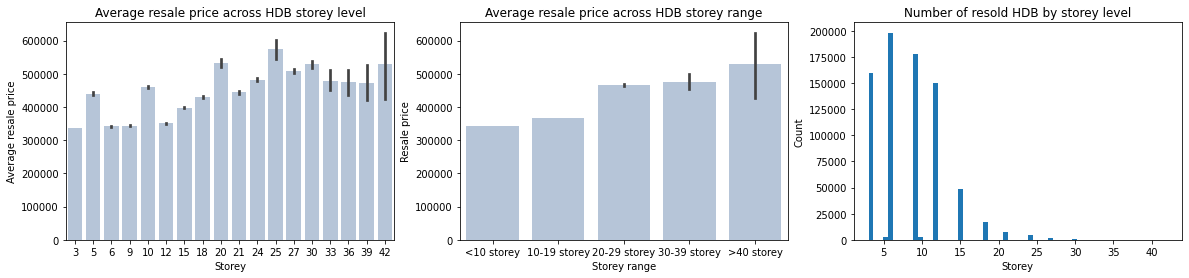

In [18]:
# Bar chart
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
sns.barplot(x='storey',
            y='resale_price_adjusted',
            data=hdb_df,
            color='lightsteelblue')

plt.title('Average resale price across HDB storey level', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Storey')

plt.subplot(1,3,3)
plt.hist(hdb_df['storey'], bins=60)

plt.title('Number of resold HDB by storey level', size=12)
plt.ylabel('Count')
plt.xlabel('Storey')

plt.subplot(1,3,2)

labels = ['<10 storey', '10-19 storey', '20-29 storey', '30-39 storey', '>40 storey']
bins = np.arange(0, 55, 10).tolist()

hdb_df['storey_coded'] = pd.cut(hdb_df['storey'], bins, labels=labels)

sns.barplot(x='storey_coded',
            y='resale_price_adjusted',
            data=hdb_df,
            color='lightsteelblue')

plt.title('Average resale price across HDB storey range', size=12)
plt.ylabel('Resale price')
plt.xlabel('Storey range');

**2) Calculate and categorize building age**

- I will use `lease_commence_date` to calculate building age by equal year intervals, and will group them into 3 general age groups: 

> old (1966 to 1982), middle (1983 to 2000) , new (2001 to 2019)

- The idea is that the older the lease commence date, the older the building age too.

Looks like **the newer the building age, or the more recent the commence date, the higher the average resale price.**

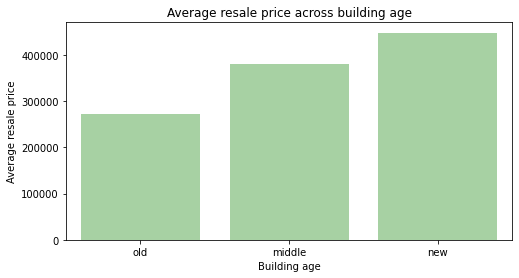

In [19]:
# Bar chart
plt.figure(figsize=(8,4))

sns.barplot(x='flat_age',
            y='resale_price_adjusted',
            data=hdb_df,
            color='#a1d99b')
plt.title('Average resale price across building age', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Building age');

<a id='feature_engineering'></a>
## Feature engineering

Any non-numerical values would need to be converted to integers or floats to be utilized in machine learning libraries, such as the one that I will be using for my multiple linear regression model. 

I have a total of 4 categorical variables: flat type, flat storey, building age, and town. 

I will be implementing either one of [label encoding](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd) or [one hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to these categorical variables, depending on whether or not they are nominal or ordinal in characteristic. 

One thing to note is that some variables have many categories to them, so simply encoding them to their respective numbers would increase the dimensionality of the model, which isn't ideal. For example, we have more than 10 towns in our dataset. In this case, I will group the towns into their corresponding market segments of CCR, RCR or OCR. 

**1) Encoding flat types**

- There are 7 different, unique HDB flat types. These are 1 room, 2 room, 3 room, 4 room, 5 room, executive, and multi-generation rooms.

We see that there are stark differences in resale price between several types of flats.

**1 room, 2 room, and 3 room flats commanded lower average resale prices, followed by 4 room and 5 room flats, and lastly with executive and multi-generation flats that are the most expensive.**

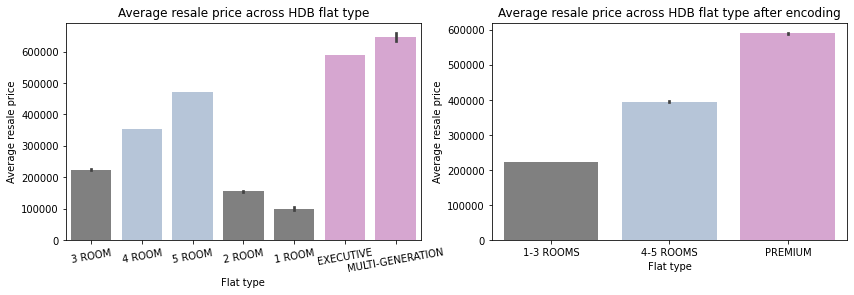

In [20]:
# Bar chart
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
sns.barplot(x='flat_type',
            y='resale_price_adjusted',
            data=hdb_df,
            palette=['gray', 'lightsteelblue', 'lightsteelblue',
                     'gray', 'gray', '#de9ed6', '#de9ed6'])

plt.title('Average resale price across HDB flat type', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Flat type')
plt.xticks(rotation=10)

plt.subplot(1,2,2)
sns.barplot(x='flat_type_updated',
            y='resale_price_adjusted',
            data=hdb_df,
            palette=['gray', 'lightsteelblue', '#de9ed6'])

plt.title('Average resale price across HDB flat type after encoding', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Flat type');

**2) Encoding towns**

- I have a total of 27 unique towns in my dataset, which I will map to their market segments according to this [Singapore District Map.](https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-21045#:~:text=The%20Core%20Central%20Region%2C%20also,in%20Singapore%20can%20be%20found.)

The bar chart below shows that **Pasir Ris, Punggol, Bukit Timah, Bishan, and Sengkang are the top 5 neighborhoods commanding the highest HDB resale prices. On the other hand, the lowest priced neighborhood is Queenstown.**

When grouped into market segments, we see that **flats in RCR commanded the highest absolute resale prices than CCR and OCR.** 

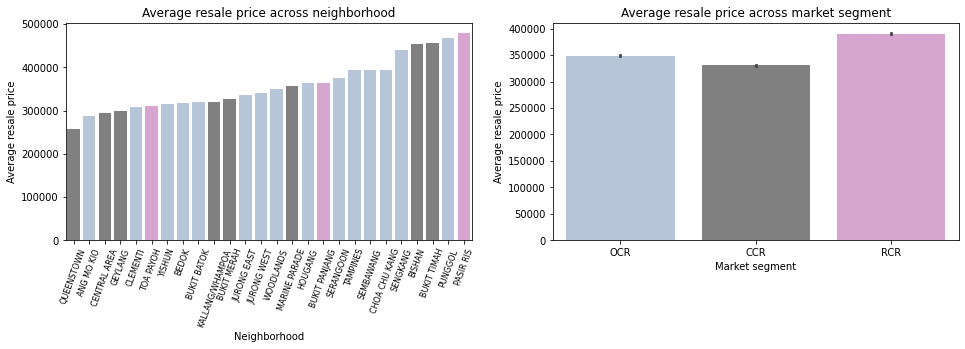

In [21]:
# Bar chart
price_town = hdb_df.groupby('town')['resale_price_adjusted'].mean().reset_index().sort_values('resale_price_adjusted')

plt.figure(figsize=(16,4))

color_dict = {'CCR':'gray', 'OCR':'lightsteelblue', 'RCR':'#de9ed6'}

plt.subplot(1,2,1)
sns.barplot(x='town',
            y='resale_price_adjusted',
            data=price_town,
            palette=[color_dict['CCR'], color_dict['OCR'], color_dict['CCR'],
                     color_dict['CCR'], color_dict['OCR'], color_dict['RCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['OCR'],
                     color_dict['CCR'], color_dict['CCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['CCR'],
                     color_dict['OCR'], color_dict['RCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['CCR'], color_dict['CCR'],
                     color_dict['OCR'], color_dict['RCR']])

plt.title('Average resale price across neighborhood', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Neighborhood')
plt.xticks(rotation=70, size=8)

plt.subplot(1,2,2)

sns.barplot(x='market_segment',
            y='resale_price_adjusted',
            data=hdb_df,
            palette=['lightsteelblue', 'gray', '#de9ed6'])

plt.title('Average resale price across market segment', size=12)
plt.ylabel('Average resale price')
plt.xlabel('Market segment');

In the map below, **we see that the expensive neighborhoods are generally clustered to the North-East regions of Singapore.** This is characterised by the pink colored regions, which indicate higher absolute prices in a scale of 0 and 900,000 SGD. 

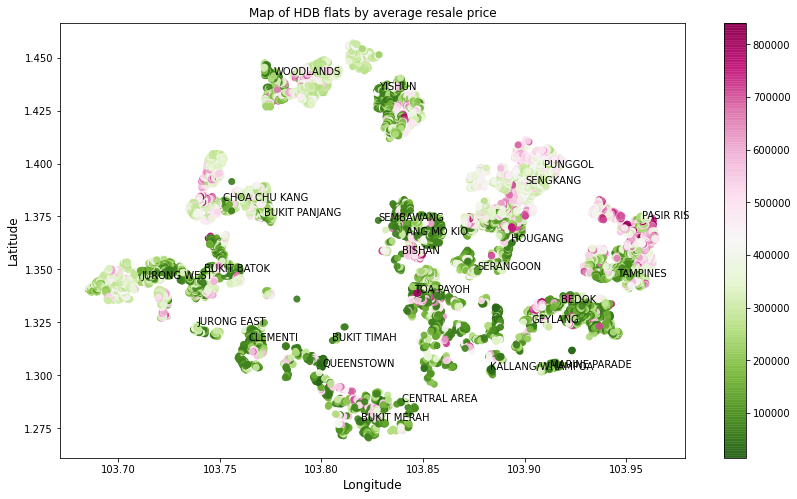

In [22]:
# Get table of all unique towns and their coordinates for annotation
town_add = hdb_df.drop_duplicates('town')[['town', 'latitude', 'longitude']]

# MRT
price_add = hdb_df.drop_duplicates(['address'], keep='first').groupby('address')['resale_price_adjusted'].mean().to_frame().reset_index()

price_add_table = pd.merge(left=price_add, 
                           right=hdb_df[['address', 'latitude', 'longitude']],
                           on='address', 
                           how='left').drop_duplicates('address', keep='first')

# Visualise 
plt.figure(figsize=[14,8])

# Plot HDB flats and their average prices
plt.scatter(x=price_add_table['longitude'],
            y=price_add_table['latitude'],
            c=price_add_table['resale_price_adjusted'],
            cmap='PiYG_r',
            alpha=0.9)

# Annotate town names
for i,j in town_add.iterrows():
    plt.text(j['longitude'], j['latitude'], j['town'], size=10)
    
plt.title('Map of HDB flats by average resale price', size=12)
plt.xlabel('Longitude', size=12)
plt.ylabel('Latitude', size=12)
plt.colorbar();

However, when we take the flat sizes into account, we see that **most HDB flats in CCR were sold for highest prices per square meter than those in RCR and OCR.**

The price hierarchy saw a reverse in pattern from the above charts - meaning to say that **people are willing to pay much more to stay in flats that are smaller in size, but are located in CCR.** There must be other characteristics of the central regions that are attractive to buyers. 

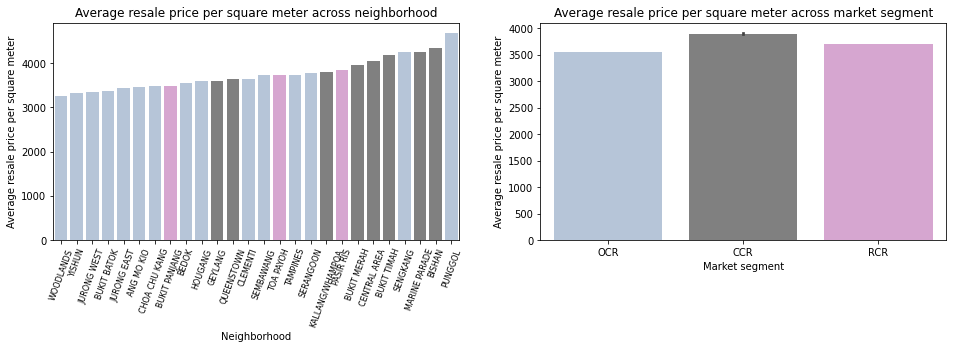

In [23]:
# Bar chart
price_town = hdb_df.groupby('town')['resale_price_adj_per_sqm'].mean().reset_index().sort_values('resale_price_adj_per_sqm')

plt.figure(figsize=(16,4))

color_dict = {'CCR':'gray', 'OCR':'lightsteelblue', 'RCR':'#de9ed6'}

plt.subplot(1,2,1)
sns.barplot(x='town',
            y='resale_price_adj_per_sqm',
            data=price_town,
            palette=[color_dict['OCR'], color_dict['OCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['RCR'], color_dict['OCR'],
                     color_dict['OCR'], color_dict['CCR'], color_dict['CCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['RCR'],
                     color_dict['OCR'], color_dict['OCR'], color_dict['CCR'],
                     color_dict['RCR'], color_dict['CCR'], color_dict['CCR'],
                     color_dict['CCR'], color_dict['OCR'], color_dict['CCR'],
                     color_dict['CCR'], color_dict['OCR']])

plt.title('Average resale price per square meter across neighborhood', size=12)
plt.ylabel('Average resale price per square meter')
plt.xlabel('Neighborhood')
plt.xticks(rotation=70, size=8)

plt.subplot(1,2,2)

sns.barplot(x='market_segment',
            y='resale_price_adj_per_sqm',
            data=hdb_df,
            palette=['lightsteelblue', 'gray', '#de9ed6'])

plt.title('Average resale price per square meter across market segment', size=12)
plt.ylabel('Average resale price per square meter')
plt.xlabel('Market segment');

<a id='relationship'></a>
## Relationship between distance of flat to amenity and resale price

From observing the scatterplots below, **the distance parameters do not strike me as being strong determinants of resale price.** In fact, these insights may be affirmed in the correlation matrix that I plot below the scatterplots.

Moreover, coming into this analysis with the assumption that home price would increase when distance to public amenities decrease, I am surprised that the charts seem to be showing me the opposite - the shorter the distance the HDB flat is to MRT stations, CBD, and public parks, the lower the average resale price. 

Another observation that I note is that the variability in price is higher for homes that are located closest to public amenities, suggesting that other factors come into play in determining home prices. 

It might be that the effect of public amenity convenience on home prices in Singapore in particular is lessen, due to the relatively ubiquitous nature of public amenity availability in the city nation. 

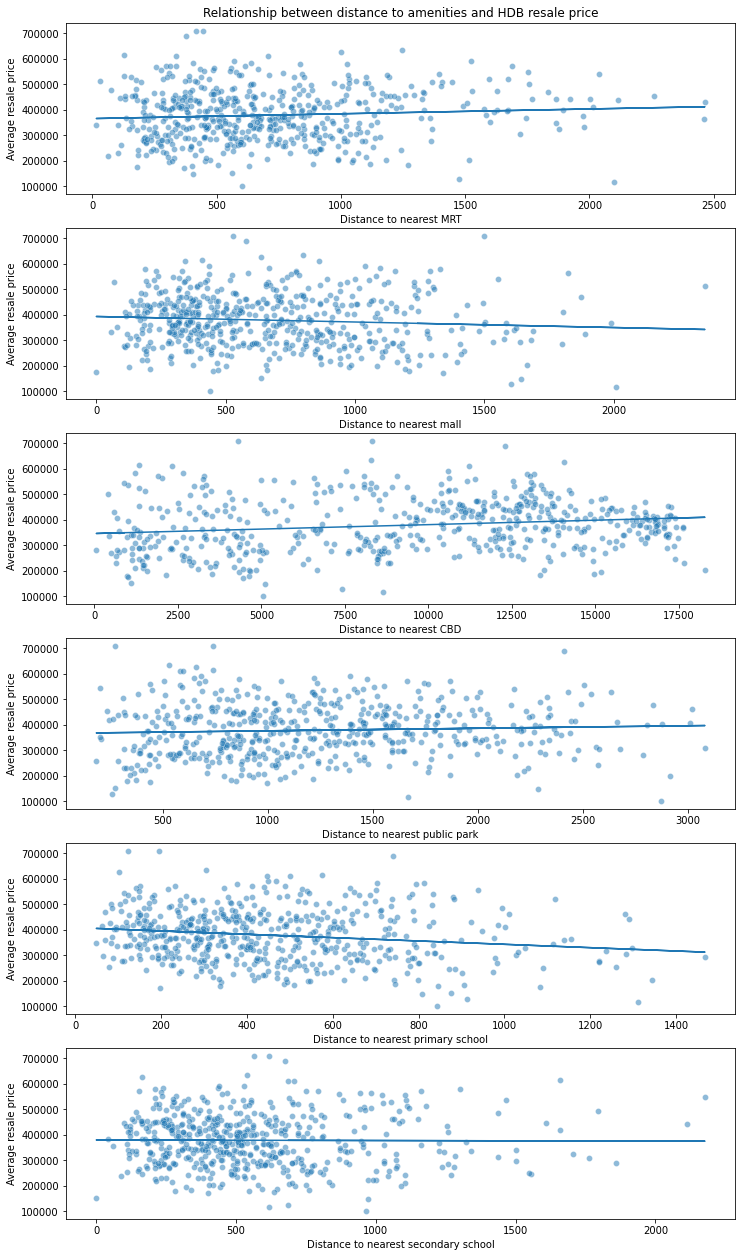

In [24]:
# Define function to plot regression line
def reg_line_plot(x_series, y_series):
    m, b = np.polyfit(x_series, y_series, 1)
    plt.plot(x_series, m*x_series+b)

# Mean
street_price_mean_no_outlier = hdb_df.groupby('street_name')['resale_price_adjusted'].mean().to_frame().reset_index()
street_merge_no_outlier = hdb_df.drop_duplicates('street_name', keep='first')[['street_name','latitude','longitude',
                                                                                          'min_distance_to_mrt_(m)', 
                                                                                          'min_distance_to_mall_(m)',
                                                                                          'min_distance_to_cbd_(m)',
                                                                                          'min_distance_to_park_(m)',
                                                                                          'min_distance_to_primary_sch_(m)',
                                                                                          'min_distance_to_sec_sch_(m)',
                                                                                          'flat_type_updated']]

street_price_mean_no_outlier_result = pd.merge(left=street_price_mean_no_outlier, right=street_merge_no_outlier,
                                    on='street_name', how='outer')

# Plot
plt.figure(figsize=(12,22))

y = street_price_mean_no_outlier_result['resale_price_adjusted']

plt.subplot(6,1,1)
x1 = street_price_mean_no_outlier_result['min_distance_to_mrt_(m)']
sns.scatterplot(x=x1,
                y=y, 
                palette='hls',
                alpha=0.5)
reg_line_plot(x1, y)
plt.title('Relationship between distance to amenities and HDB resale price',
          size=12)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest MRT')

plt.subplot(6,1,2)
x2 = street_price_mean_no_outlier_result['min_distance_to_mall_(m)']
sns.scatterplot(x=x2,
                y=y,
                palette='hls', alpha=0.5)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest mall')
reg_line_plot(x2, y)

plt.subplot(6,1,3)
x3 = street_price_mean_no_outlier_result['min_distance_to_cbd_(m)']
sns.scatterplot(x=x3,
                y=y,
                palette='hls', alpha=0.5)
reg_line_plot(x3, y)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest CBD')

plt.subplot(6,1,4)
x4 = street_price_mean_no_outlier_result['min_distance_to_park_(m)']
sns.scatterplot(x=x4,
                y=y,
                palette='hls', alpha=0.5)
reg_line_plot(x4, y)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest public park')

plt.subplot(6,1,5)
x5 = street_price_mean_no_outlier_result['min_distance_to_primary_sch_(m)']
sns.scatterplot(x=x5,
                y=y,
                palette='hls', alpha=0.5)
reg_line_plot(x5, y)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest primary school')

plt.subplot(6,1,6)
x6 = street_price_mean_no_outlier_result['min_distance_to_sec_sch_(m)']
sns.scatterplot(x=x6,
                y=y,
                palette='hls', alpha=0.5)
reg_line_plot(x6, y)
plt.ylabel('Average resale price')
plt.xlabel('Distance to nearest secondary school');

<a id='correlation_matrix'></a>
## Correlation matrix

Now that I have my data fit for analysis, I want to look at how each variable correlate with each other, as well as with the resale price.

The matrix below shows us the correlation coefficients between every variable of interest, along with their color gradients of red/orange hues indicating higher correlation scores and blue indicating lower scores.

A correlation coefficient is a measure of the strength of the relationship between two variables, ranging from -1.0 (perfect negative correlation) to +1.0 (perfect positive correlation).

If we look at the bottom-est row of the correlation matrix below, which shows us the correlation coefficients for each variable of interest with resale price, we see that **resale price is strongly correlated with floor area**, at 0.79. Other variables of interest with strong correlations with resale price include building age and flat type. In particular, a premium flat type seems to have a stronger correlation to resale price than the other types. 

Nevertheless, the strong correlation between resale price and floor area cannot be generalised to flats of all regions in Singapore, and says nothing about the attractiveness of a home (which translates to how much a buyer is willing to pay to stay in a home that is of a smaller size), as the earlier charts have shown that flats in CCR command higher prices per square meter as compared to homes in the other regions. 

Again, the distance parameters do not seem to correlate strongly to resale price.

In [25]:
# Select all numeric features that I want to use for the regression
num_var = ['min_distance_to_mrt_(m)', 'min_distance_to_mall_(m)', 'min_distance_to_cbd_(m)', 
           'min_distance_to_park_(m)', 'min_distance_to_primary_sch_(m)',
           'min_distance_to_sec_sch_(m)','floor_area_sqm']

# Categorical features
cat_var = ['flat_age_coded', 'flat_type_updated_4-5 ROOMS', 'flat_type_updated_PREMIUM',
           'market_segment_OCR', 'market_segment_RCR', 'storey_coded']


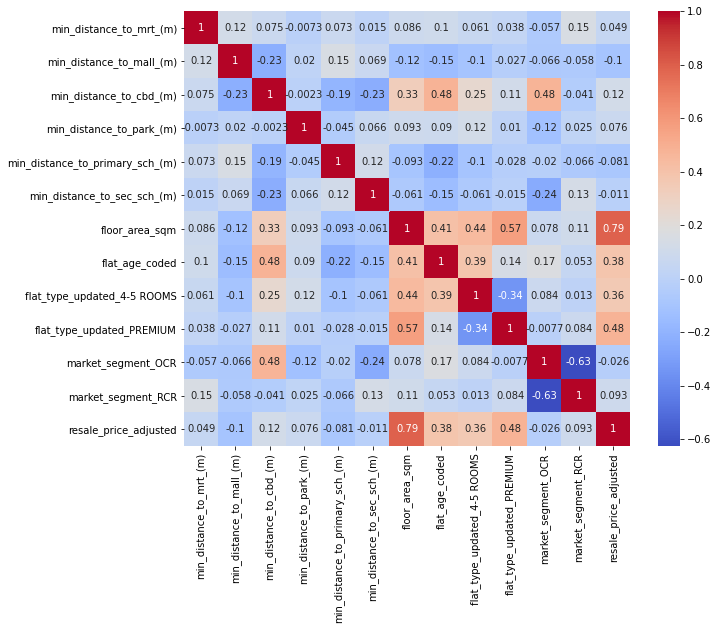

In [26]:
# Calculate correlations
corrMatrix1 = hdb_df[num_var + cat_var + ['resale_price_adjusted']].corr()

# Plot heatmap
plt.figure(figsize=[10,8])
sns.heatmap(corrMatrix1, 
            xticklabels=corrMatrix1.columns,
            yticklabels=corrMatrix1.columns,
            cmap='coolwarm',
            annot=True);

<a id='analysis'></a>
## Analyse data using multiple linear regression model

Since the focus of this exercise is to determine which variable of interest has an actual (statistically significant) relationship with HDB resale price, the multiple linear regression model that I employ here seeks to conduct hypothesis tests for each of my independent/ explanatory variable (as opposed to a predictive focus of the model).

Therefore, it is important that I handle any multicollinearity in my data. The presence of multicollinearity means that there are correlations between my independent variables themselves. Failing to remove the effect of multicollinearity reduces the model's power in identifying which variable is statistically significant, and poses difficulties to me when [interpreting the individual model coefficients](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/). Meaning, the model would not be precise in [distinguishing the individual effects](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/) of each variable on resale price. 

A way to determine if multicollinearity is present is to calculate the variance inflation factor (VIF). A rule of thumb is that a VIF score of above 5 is indicative of the presence of multicollinearity, whereas a score of above 10 is indicative of a strong multicollinearity.

The table below shows me that there is a very strong correlation between my independent variables of interest, particularly with floor area. Thus, I remove this variable from my analysis.

In [27]:
hdb_df['storey_coded'] = hdb_df['storey_coded'].cat.codes
hdb_df['storey_coded']

vif_data = pd.DataFrame()
vif_data['feature'] = hdb_df[num_var + cat_var].columns
vif_data['VIF'] = [variance_inflation_factor(hdb_df[num_var + cat_var].values, i) for i in range(len(hdb_df[num_var + cat_var].columns))]
vif_data

,feature,VIF
0,min_distance_to_mrt_(m),5.002207
1,min_distance_to_mall_(m),4.173908
2,min_distance_to_cbd_(m),14.581768
3,min_distance_to_park_(m),4.964349
4,min_distance_to_primary_sch_(m),4.202257
5,min_distance_to_sec_sch_(m),3.978773
6,floor_area_sqm,37.797574
7,flat_age_coded,4.425026
8,flat_type_updated_4-5 ROOMS,6.932460
9,flat_type_updated_PREMIUM,3.215354


I will be using [Statsmodels](https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9) to perform my linear regression, with the Ordinary Least Squares method, which simply means that the regression line I am fitting aims to minimize the square of distance from the regression line.

In [28]:
# Remove floor_area_sqm from analysis
num_var.remove('floor_area_sqm')

X = hdb_df[num_var + cat_var]
y = hdb_df['resale_price_adjusted']

# Add intercept
X = sm.add_constant(X)

# Instantiate and fit model
model1 = sm.OLS(y,X).fit()

# Predict
predictions1 = model1.predict(X)

# Effect summary table
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     resale_price_adjusted   R-squared:                       0.589
Model:                               OLS   Adj. R-squared:                  0.589
Method:                    Least Squares   F-statistic:                 9.196e+04
Date:                   Tue, 20 Jul 2021   Prob (F-statistic):               0.00
Time:                           14:49:30   Log-Likelihood:            -9.8946e+06
No. Observations:                 770488   AIC:                         1.979e+07
Df Residuals:                     770475   BIC:                         1.979e+07
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            2.699e+05    582.922    463.069      0.000    2.69e+05    2.71e+05
min_distance_to_mrt_(m)            -5.3812      0.283    -19.009      0.000      -5.936      -4.826
min_distance_to_mall_(m)          -13.8835      0.268    -51.732      0.000     -14.409     -13.357
min_distance_to_cbd_(m)            -5.8169      0.035   -166.996      0.000      -5.885      -5.749
min_distance_to_park_(m)           -3.9570      0.177    -22.372      0.000      -4.304      -3.610
min_distance_to_primary_sch_(m)    -0.0695      0.445     -0.156      0.876      -0.941       0.802
min_distance_to_sec_sch_(m)         7.9133      0.368     21.501      0.000       7.192       8.635
flat_age_coded                   3.768e+04    233.622    161.305      0.000    3.72e+04    3.81e+04
flat_type_updated_4-5 ROOMS      1.667e+05    258.258    645.395      0.000    1.66e+05    1.67e+05
flat_type_updated_PREMIUM        3.637e+05    442.080    822.598      0.000    3.63e+05    3.65e+05
market_segment_OCR              -2992.4390    398.535     -7.509      0.000   -3773.554   -2211.324
market_segment_RCR               1846.1244    481.539      3.834      0.000     902.324    2789.924
storey_coded                     2.236e+04    208.774    107.114      0.000     2.2e+04    2.28e+04
==============================================================================
Omnibus:                     4921.622   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5020.809
Skew:                           0.195   Prob(JB):                         0.00
Kurtosis:                       3.068   Cond. No.                     7.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpreting the summary table**

- The model is only able to explain 58.9% of the variance of resale price.
- The model's overall p-value (F statistic) tells me that the model is statistically significant.
- When zooming into the p-values of each independent variable of interest, we see that all are significant at an alpha value of 5%, except for distance to primary school, meaning this particular variable has no relationship to resale price. 
- The model coefficients tell me the expected effect of a unit change of each independent variable on the average resale price
- For example, a flat that is of the premium type is expected to command a resale price that is 363,370 SGD higher as compared to a flat that is of the 1 room, 2 room, and 3 room type. 
- As with our distance variables, it looks like the further away a HDB flat is from its nearest MRT station, mall, CBD, and park, the lower the expected average resale price.
- On the other hand, the further away a flat is from its nearest secondary school, the higher the expected resale price.
- All in all, it seems like flat type is the strongest determinant of resale price, when taken the variables that I had included in my analysis.

<a id='limitations'></a>
## Limitations

**1. Non-exhaustive list of independent variables**

I had only managed to incorporate a limited set of variables, most of which pertain to the characteristics of a home and its surrounding amenities (from a convenience-distance standpoint). 

Home prices are affected by others factors, and I would have liked to explore more variables such as those related to population demographics. 

I would have also liked to further disaggregate my analysis to be based on certain neighborhood clusters, in hopes of being able to study the neighborhood-specific characteristics. 

What is it about Punggol that is attracting expensive sales? Are most HDB flats in Punggol sized larger than flats in the other neighborhoods?

What is it about flats in CCR that although smaller in size, command higher prices per square meter? Are there certain types of people who tend to purchase these flats?

**2. Calculating distances**

I used the Harversine formula to calculate the distance between two points, which accounts for the fact that the earth is a curved surface.

However, the calculated distance may not reflect the actual distance that a person would have to actually take to travel from point A to B. There may be obstructions or infrastructure-related detours that one has to take. 

This may be improved by using Google Maps API to calculate *travel time*.

In [30]:
# to remove code cells from being seen in html: https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename("What affects HDB prices in Singapore?.ipynb")

# Write to output html file
with open("entry12.html",  "w") as f:
    f.write(output[0])